# Introduction

Aeronaut, a bar/brewery in Somerville MA, has "indie trivia" every Tuesday, in which anyone can sign up to host. You come up with your own themes, write your own questions, and decide on the music you want to play between rounds. In November my friend Zack and I hosted. We spent awhile coming up with questions, and one of the biggest challenges was calibrating the question difficulty -- we had a lot discussions about whether a question would be too hard, too easy, or just right. Ultimately I think our trivia night turned out really well, but fortunately we also have data to test this belief more rigorously! Thanks to our scorekeeper Sarah, who went above and beyond the call of duty, we have the results for each question, for each team (rather than just the aggregate scores). This allows us to conduct granular question-level analysis to see how hard each question was. Additionally, using Item Response Theory, we can see how useful each question was for assessing team trivia proficiency.


**tl;dr** -- Item Response Theory is a useful technique for understanding everyday Somerville nerd situations such as going to trivia.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.special import expit
from theano import shared

import seaborn as sns

pd.set_option('display.max_columns', 100)
%matplotlib inline

# Initial Analysis

In [2]:
df = pd.read_csv('trivia_data_cleaned.csv')
question_cols = df.columns.tolist()
question_cols.remove('team_id')
question_cols.remove('final_score')
df.head(3).T

,0,1,2
r1q1,False,False,False
r1q2,False,False,False
r1q3,True,True,True
r1q4,False,False,False
r1q5,False,False,True
r1q6,False,True,False
r2q1,False,False,False
r2q2,False,True,True
r2q3,False,False,False
r2q4,False,True,False


We had 36 teams and 30 questions. One of the initial things we can answer pretty quickly is what the distribution of team ability and question easiness looks like. Here we simply measure team ability as the percent of questions they got right and question easiness as the percent of teams that answered a question correctly.

We see below that there was a good range of correctness rates for each team (1.0 would mean they got all questions right):

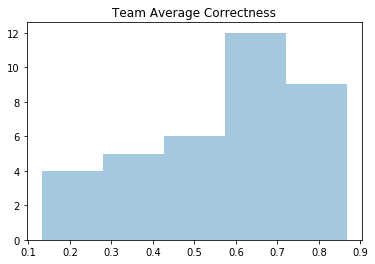

In [25]:
sns.distplot(df[question_cols].mean(axis=1), kde=False)
plt.title("Team Average Correctness");

And that there was a range in question difficulty (a 1 means every team got it right, a 0 means they all got it wrong)

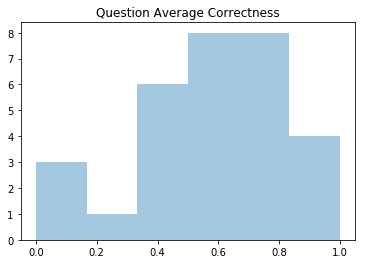

In [26]:
sns.distplot(df[question_cols].mean(), kde=False)
plt.title("Question Average Correctness");

# Building a Model

Using this raw data alone, we can identify which questions were so hard that nobody got them right; we'd probably want to avoid those in the future. But what about the questions in the middle of the distribution? Are some of those better than others? What do we mean by "better" in this case, anyway? One approach is to think of good questions as those that give us a lot of information about the team's underlying skill (at trivia). In this case our best estimate of their underlying skill is their performance on all the other questions, so essentially we're interested in identifying what questions help us predict how the team will do on the trivia overall.

To do this, we can apply item-response theory, a technique used in standardized testing and assessment to determine student proficiency and question quality. The model is as follows:

Let's define some variables:
- $\theta_j$ -- each team $j$'s latent trivia skill
- $\beta_i$ -- each question $i$'s difficulty
- $\alpha_i$ -- each question $i$'s discriminability
- $y_{ij}$ = 1 if team $j$ got question $i$ correct, 0 otherwise

One of the most common item response theory models is 2PL (two-parameter logistic), which gives us the following likelihood function:

$y_{ij} \sim Bern(\sigma(\alpha_i \theta_j - \beta_i))$

Where $\sigma(\cdot)$ is the logistic function.

Or in English, the probability of a given team answering a given question correctly is a function of that team's latent skill minus that question's difficulty. A more discriminative question has a stronger relationship between skill and whether or not the team gets the question right (the slope of the logistic is steeper).

Our aim is to estimate these question parameters (and team parameters) using the available data. We set that up in a Bayesian framework, specifying priors for our latent parameters and using MCMC to get posterior distributions for them. For more thorough analyses of Bayesian IRT, check out this [Stan post](https://mc-stan.org/users/documentation/case-studies/tutorial_twopl.html) and [this post](https://austinrochford.com/posts/2017-04-04-nba-irt.html) from Austin Rochford using IRT to analyze NBA games.

In [5]:
df_long = pd.melt(df.drop(columns='final_score'), id_vars=['team_id'])
df_long.columns = ['team_name', 'question_name', 'correct']
df_long['round'] = df_long.question_name.str[:2]

I had been finding some odd results for the questions in the last round. I suspected this might be due to selection bias -- teams that weren't doing well might have left before the end of triva, so I removed all teams (designated "quitters" in the code below) that got no questions right in the last round

In [6]:
team_round_correct = df_long.groupby(['team_name', 'round'])['correct'].sum().reset_index()
quitters = team_round_correct[(team_round_correct['round'] == 'r5') & 
                              (team_round_correct['correct'] == 0)]['team_name']
df_long = df_long[~(df_long['team_name'].isin(quitters))]

uniq_questions, question_idx = np.unique(df_long['question_name'], return_inverse=True)
uniq_teams, team_idx = np.unique(df_long['team_name'], return_inverse=True)
n_questions = len(uniq_questions)
n_teams = len(uniq_teams)

In [7]:
# Hold out random observations
np.random.seed(158)
def subset_data(question_idx, team_idx, correct, subset_idx):
    return question_idx[subset_idx], team_idx[subset_idx], correct[subset_idx]

train_idx = np.random.rand(len(df_long)) < 0.8
question_idx_train, team_idx_train, correct_train = subset_data(question_idx, team_idx, df_long['correct'].values,
                                                                train_idx)
question_idx_test, team_idx_test, correct_test = subset_data(question_idx, team_idx, df_long['correct'].values,
                                                             ~train_idx)

In [8]:
question_idx_shared = shared(question_idx_train)
team_idx_shared = shared(team_idx_train)
with pm.Model() as twopl:
    difficulty_sd = pm.HalfCauchy('difficulty_sd', 1)
    difficulty = pm.Normal('difficulty', mu=0, sd=difficulty_sd, shape=n_questions)
    discrim = pm.Lognormal('discrim', mu=0, sd=0.5, shape=n_questions)
    
    skill_mu = pm.Normal('skill_mu', 0, 1)
    skill_sd = pm.HalfCauchy('skill_sd', 1)
    skill = pm.Normal('skill', mu=skill_mu, sd=skill_sd, shape=n_teams)
    
    logit_p = discrim[question_idx_shared] * skill[team_idx_shared] - difficulty[question_idx_shared]
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=correct_train)

In [9]:
with twopl:
    prior_samples = pm.sample_prior_predictive()
    twopl_trace = pm.sample(draws=2000, chains=8, target_accept=0.999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [skill, skill_sd, skill_mu, discrim, difficulty, difficulty_sd]
Sampling 8 chains: 100%|██████████| 20000/20000 [01:39<00:00, 200.97draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
with twopl:
    posterior_samples = pm.sample_posterior_predictive(twopl_trace)

100%|██████████| 16000/16000 [00:13<00:00, 1177.67it/s]


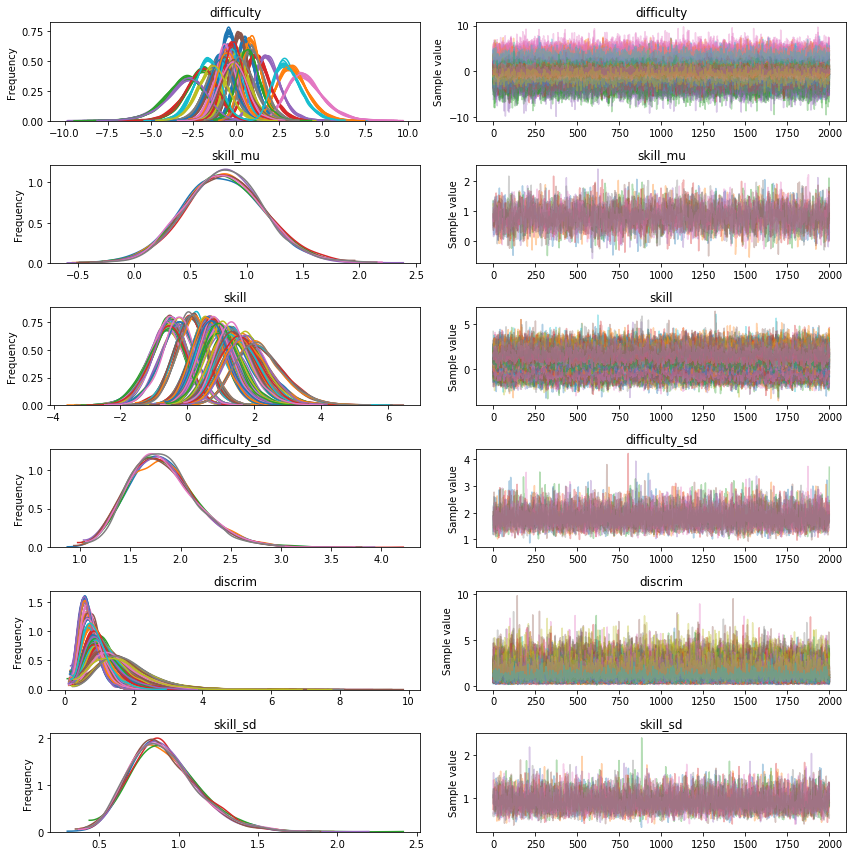

In [11]:
pm.traceplot(twopl_trace);

In [12]:
def forestplot(trace, varname):
    with plt.style.context('seaborn-darkgrid'):
        plt.figure(figsize=(6, 6))
        pm.forestplot(trace, varnames=[varname],
                      chain_spacing=1e-2,
                      ylabels=['' for _ in range(trace[varname].shape[1])],
                      plot_kwargs={'fontsize': 14},
                      main=f'95% Credible Intervals: {varname}', xtitle=varname);
        


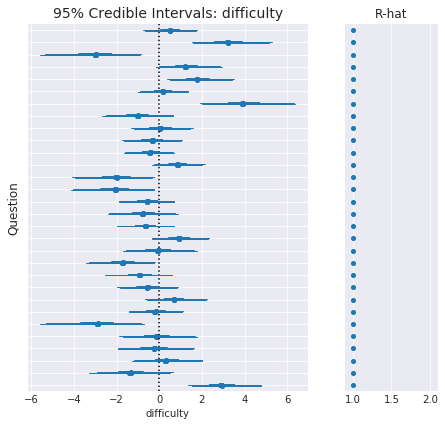

In [13]:
forestplot(twopl_trace, 'difficulty')
plt.ylabel("Question", fontsize=12);

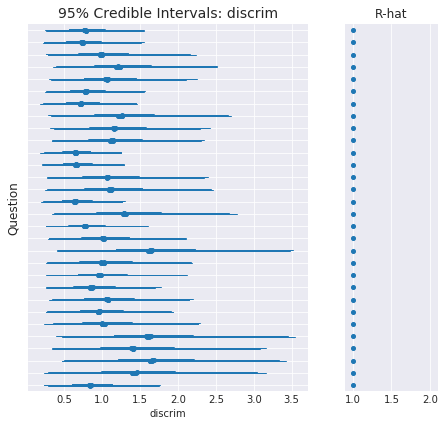

In [14]:
forestplot(twopl_trace, 'discrim')
plt.ylabel("Question", fontsize=12);

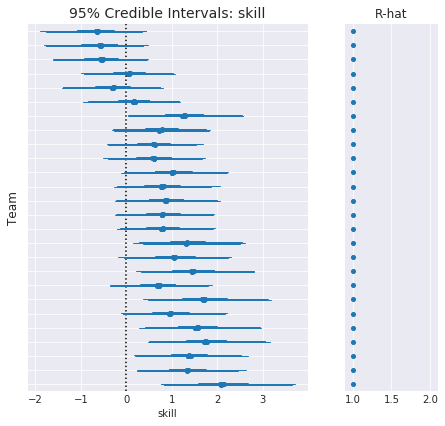

In [15]:
forestplot(twopl_trace, 'skill')
plt.ylabel("Team", fontsize=12);

In [16]:
question_params = pd.DataFrame({'difficulty': twopl_trace['difficulty'].mean(axis=0),
                                 'discrim': twopl_trace['discrim'].mean(axis=0)},
                              index=uniq_questions)
question_params['avg_correct'] = df_long.groupby('question_name')['correct'].mean()


## Diagnosing the fit

In [17]:
# Lifted directly from https://austinrochford.com/posts/2017-04-04-nba-irt.html
def energy_plot(trace):
    energy = trace['energy']
    energy_diff = np.diff(energy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(energy - energy.mean(), bins=30,
            lw=0, alpha=0.5,
            label="Energy")
    ax.hist(energy_diff, bins=30,
            lw=0, alpha=0.5,
            label="Energy difference")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.legend()

We want these to be close. This looks pretty good

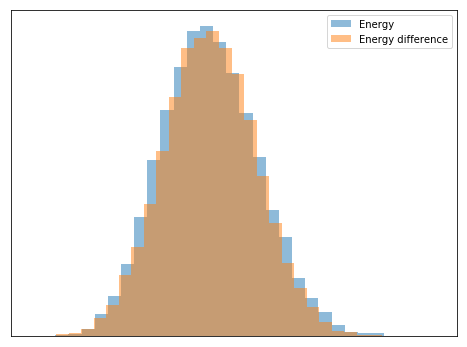

In [18]:
energy_plot(twopl_trace)

### Predicting on held-out data

I held out random observations, so given our estimate of the team's ability and the question's difficulty we can predict the probability of the team answering it correctly and compare that to whether or not they actually did. The plot below shows the observed % correct for held-out observations, binned by the model's predicted $p(correct)$. The plot is roughly the shape we want: observations with higher predicted probability are on average more likely to be correctly answered

In [19]:
question_idx_shared.set_value(question_idx_test)
team_idx_shared.set_value(team_idx_test)
with twopl:
    predicted_correct = pm.sample_posterior_predictive(twopl_trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1225.85it/s]


In [20]:
evaluation_df = pd.DataFrame({'team': team_idx_test, 'question': question_idx_test,
                              'predicted_pcorrect': predicted_correct['likelihood'].mean(axis=0),
                              'correct': correct_test})
display(evaluation_df.sample(4))

,team,question,predicted_pcorrect,correct
12,7,1,0.091,False
162,4,29,0.065,False
24,5,4,0.164,True
82,17,14,0.820,True


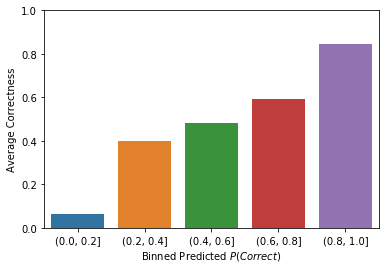

In [21]:
evaluation_df['predicted_pcorrect_bin'] = pd.cut(evaluation_df['predicted_pcorrect'], bins=np.linspace(0, 1, 6))
predicted_vs_actual = evaluation_df.groupby('predicted_pcorrect_bin')['correct'].mean()
sns.barplot(predicted_vs_actual.index.astype(str), predicted_vs_actual.values)
plt.ylim([0, 1]);
plt.xlabel("Binned Predicted $P(Correct)$")
plt.ylabel("Average Correctness");

# What does the model tell us about the questions?

The plot below shows the distribution of the posterior means for the question difficulties (higher number means more difficult). We can see a very clear relationship between empirical difficulty and the parameters that the model learns, which is a good sign that the model fits well, but also a good sign that the model isn't _really_ necessary to tell us how hard the questions are (in the specific case of my trivia dataset).

/Users/maxlivingston/Projects/trivia/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


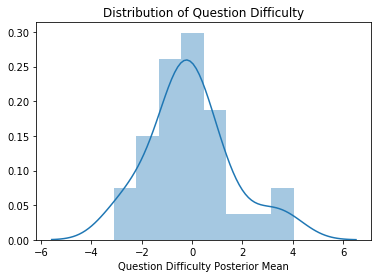

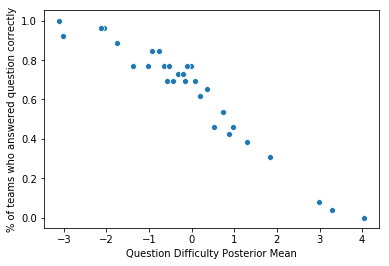

In [22]:
sns.distplot(question_params['difficulty']);
plt.title("Distribution of Question Difficulty")
plt.xlabel("Question Difficulty Posterior Mean")
plt.show()
sns.scatterplot(question_params['difficulty'], question_params['avg_correct']);
plt.xlabel("Question Difficulty Posterior Mean")
plt.ylabel("% of teams who answered question correctly");

These are the posterior means for question discriminability. They don't appear to be correlated with difficulty, which is good because it suggests we're picking up on some other characteristic of the questions that's more interesting than just their correctness rate.

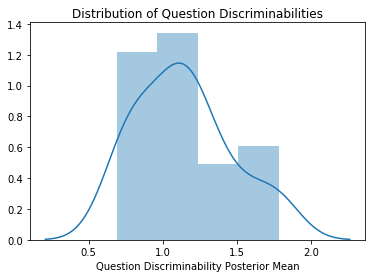

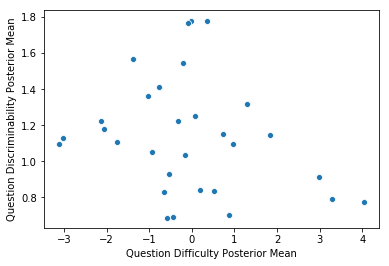

In [23]:
sns.distplot(question_params['discrim']);
plt.xlabel("Question Discriminability Posterior Mean")
plt.title("Distribution of Question Discriminabilities")
plt.show();
sns.scatterplot(question_params['difficulty'], question_params['discrim']);
plt.xlabel("Question Difficulty Posterior Mean")
plt.ylabel("Question Discriminability Posterior Mean");

# Identifying good questions

So what questions were useful for assessing a team's skill? These ones:

In [24]:
np.round(question_params.sort_values(['discrim'], ascending=False).head(10), 2)

,difficulty,discrim,avg_correct
r3q8,-0.01,1.78,0.77
r5q4,0.35,1.77,0.65
r5q2,-0.10,1.77,0.77
r5q5,-1.38,1.57,0.77
r5q3,-0.20,1.54,0.73
r3q5,-0.77,1.41,0.85
r2q2,-1.02,1.36,0.77
r1q4,1.29,1.32,0.38
r2q3,0.07,1.25,0.69
r3q3,-2.12,1.22,0.96


The best (most discriminating) question, by a nose, is Round 3 Question 8. Round 3 was a visual round in which teams were asked to identify countries/states/cities based on their flag. I thought it was a great round due to its mixture of difficulty. The specific question that turned out to be particularly informative was identifying the flag of Morocco 🇲🇦.

Round 5, which was about name changes, performs quite well by this metric. This was my personal pet round, so I'm happy that it's empirically validated, but I have absolutely no idea why this round contains four of the top 5 most discriminating questions (my previous hypothesis about selection bias of teams leaving early having hopefully been taken care of by removing the likely quitters from the data).

Round 5 Q4 asked "Although Sri Lanka gained independence from the UK in 1948, it did not change its name to Sri Lanka until 1972. What was its name before 1972, which is still associated with tea produced there?"

Round 5 Q2 asked "In 1980, Rhodesia became independent from the UK, elected as Prime Minister Robert Mugabe, who would go on to rule the country for over 30 years, and changed its name to what?"

